# CSC 673 Assignment 5:
##### Author: Md Asifur Rahman
#### Acknowledgements: 
1. movie_data_2015.csv dataset is provided by Dr Natalia khuri
2. All the scopus bibliometric data is retrieved using script provided by Dr Natalia khuri
3. Some of the GeoPy relevant code has been taken from https://geopy.readthedocs.io/en/stable/
4. For interactive map folium package has been used

## Install dependencies

In [ ]:
!pip install elsapy

In [ ]:
!pip install geopy

In [ ]:
!pip install folium

In [ ]:
!pip install geopandas

## Import dependencies

In [3]:
import pandas as pd
import numpy as np
import warnings
import os
import file_processor as fp
import parser as psr 
from tqdm import tqdm

import pickle
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn import model_selection

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules

import folium 
import geopandas as gpd
from shapely.geometry import Point
from functools import partial

warnings.filterwarnings("ignore")

## 1. Minimum Performance

In [6]:
movie_data_path_info = '../data/movie_data_2015.csv'
movie_data = pd.read_csv(movie_data_path_info)

### 1.1 Performing data preprocessing:

In [7]:
print("# Dataset instances before cleaning:", movie_data.shape[0])
missing_val_info= fp.get_missing_data_info(movie_data)
print("# Number of instance with nan:",len(missing_val_info['rows']['row_index']))
nan_cleaned_movie_data = fp.process_missing_value(movie_data, drop=True, drop_instance=True)
nan_cleaned_movie_data = nan_cleaned_movie_data.drop_duplicates()
print("# Dataset instances after cleaning:", nan_cleaned_movie_data.shape[0])

# Dataset instances before cleaning: 23047
# Number of instance with nan: 7495
# Dataset instances after cleaning: 15552


In [8]:
sorted_movie_data = nan_cleaned_movie_data.sort_values(by=['gross', 'words'], ascending=[False, False])

### 1.2 Analyzing association of gender with gross income of the movie

In [9]:
association_movie_df = pd.DataFrame()
bin_labels_3 = ['low', 'medium', 'high']
association_movie_df['gross'] = pd.qcut(sorted_movie_data['gross'], q=[0, 0.25, 0.75, 1], labels=bin_labels_3)
association_movie_df['gender']=sorted_movie_data['gender']

In [10]:
association_movie_df_dummies = pd.get_dummies(association_movie_df)
association_movie_df_enc = association_movie_df_dummies.replace({0:False, 1:True})

apriori_frequent_itemsets = apriori(association_movie_df_enc, min_support=0.1, use_colnames=True)
item = association_rules(apriori_frequent_itemsets, metric="confidence", min_threshold=0.1)
item.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(gross_low),(gender_man),0.253215,0.697788,0.167631,0.662011,0.948728,-0.009059,0.894148
1,(gender_man),(gross_low),0.697788,0.253215,0.167631,0.240232,0.948728,-0.009059,0.982912
2,(gender_man),(gross_medium),0.697788,0.497299,0.349344,0.500645,1.006728,0.002335,1.006700
3,(gross_medium),(gender_man),0.497299,0.697788,0.349344,0.702483,1.006728,0.002335,1.015779
4,(gender_woman),(gross_medium),0.302083,0.497299,0.147955,0.489783,0.984885,-0.002271,0.985268
5,(gross_medium),(gender_woman),0.497299,0.302083,0.147955,0.297517,0.984885,-0.002271,0.993500
6,(gross_high),(gender_man),0.249486,0.697788,0.180813,0.724742,1.038628,0.006725,1.097924
7,(gender_man),(gross_high),0.697788,0.249486,0.180813,0.259123,1.038628,0.006725,1.013008


### 1.3 Selecting rules with high confidence

In [11]:
item[(item['support'] >= 0.15) & (item['confidence'] >= 0.7) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(gross_medium),(gender_man),0.497299,0.697788,0.349344,0.702483,1.006728,0.002335,1.015779
6,(gross_high),(gender_man),0.249486,0.697788,0.180813,0.724742,1.038628,0.006725,1.097924


### 1.4 Visualization of patterns relevant to gender biases

#### 1.4.1 Extracting information 

In [12]:
sorted_movie_data = nan_cleaned_movie_data.sort_values(by=['gross', 'words'], ascending=[False, False])
file_directory = '../output/processed_movie_data.csv'
if not os.path.exists(file_directory):
    new_movie_dataframe = psr.transform_movie_data_info(sorted_movie_data, file_directory)
else:
    new_movie_dataframe = pd.read_csv(file_directory, index_col=[0])

In [13]:
new_movie_dataframe_cpy = new_movie_dataframe.copy()

In [14]:
new_movie_dataframe_cpy.head(2)

,title,release_year,gross,no_of_male_characters,no_of_female_characters,total_words_male_characters,total_words_female_characters,lead_male_character_word,lead_female_character_word
0,Star Wars: Episode IV - A New Hope,1977,1798.0,13,1,9221,636,2485,636
1,Titanic,1997,1249.0,11,6,6873,4683,2607,2792


In [15]:
top_100_gross_income_movies = new_movie_dataframe_cpy.sort_values(by=['gross'], ascending=[False])[0:100]
new_movie_data_sorted_by_year = new_movie_dataframe_cpy.sort_values(by=['release_year','gross', 'lead_male_character_word', 'lead_female_character_word'], ascending=[True, False, False,False])

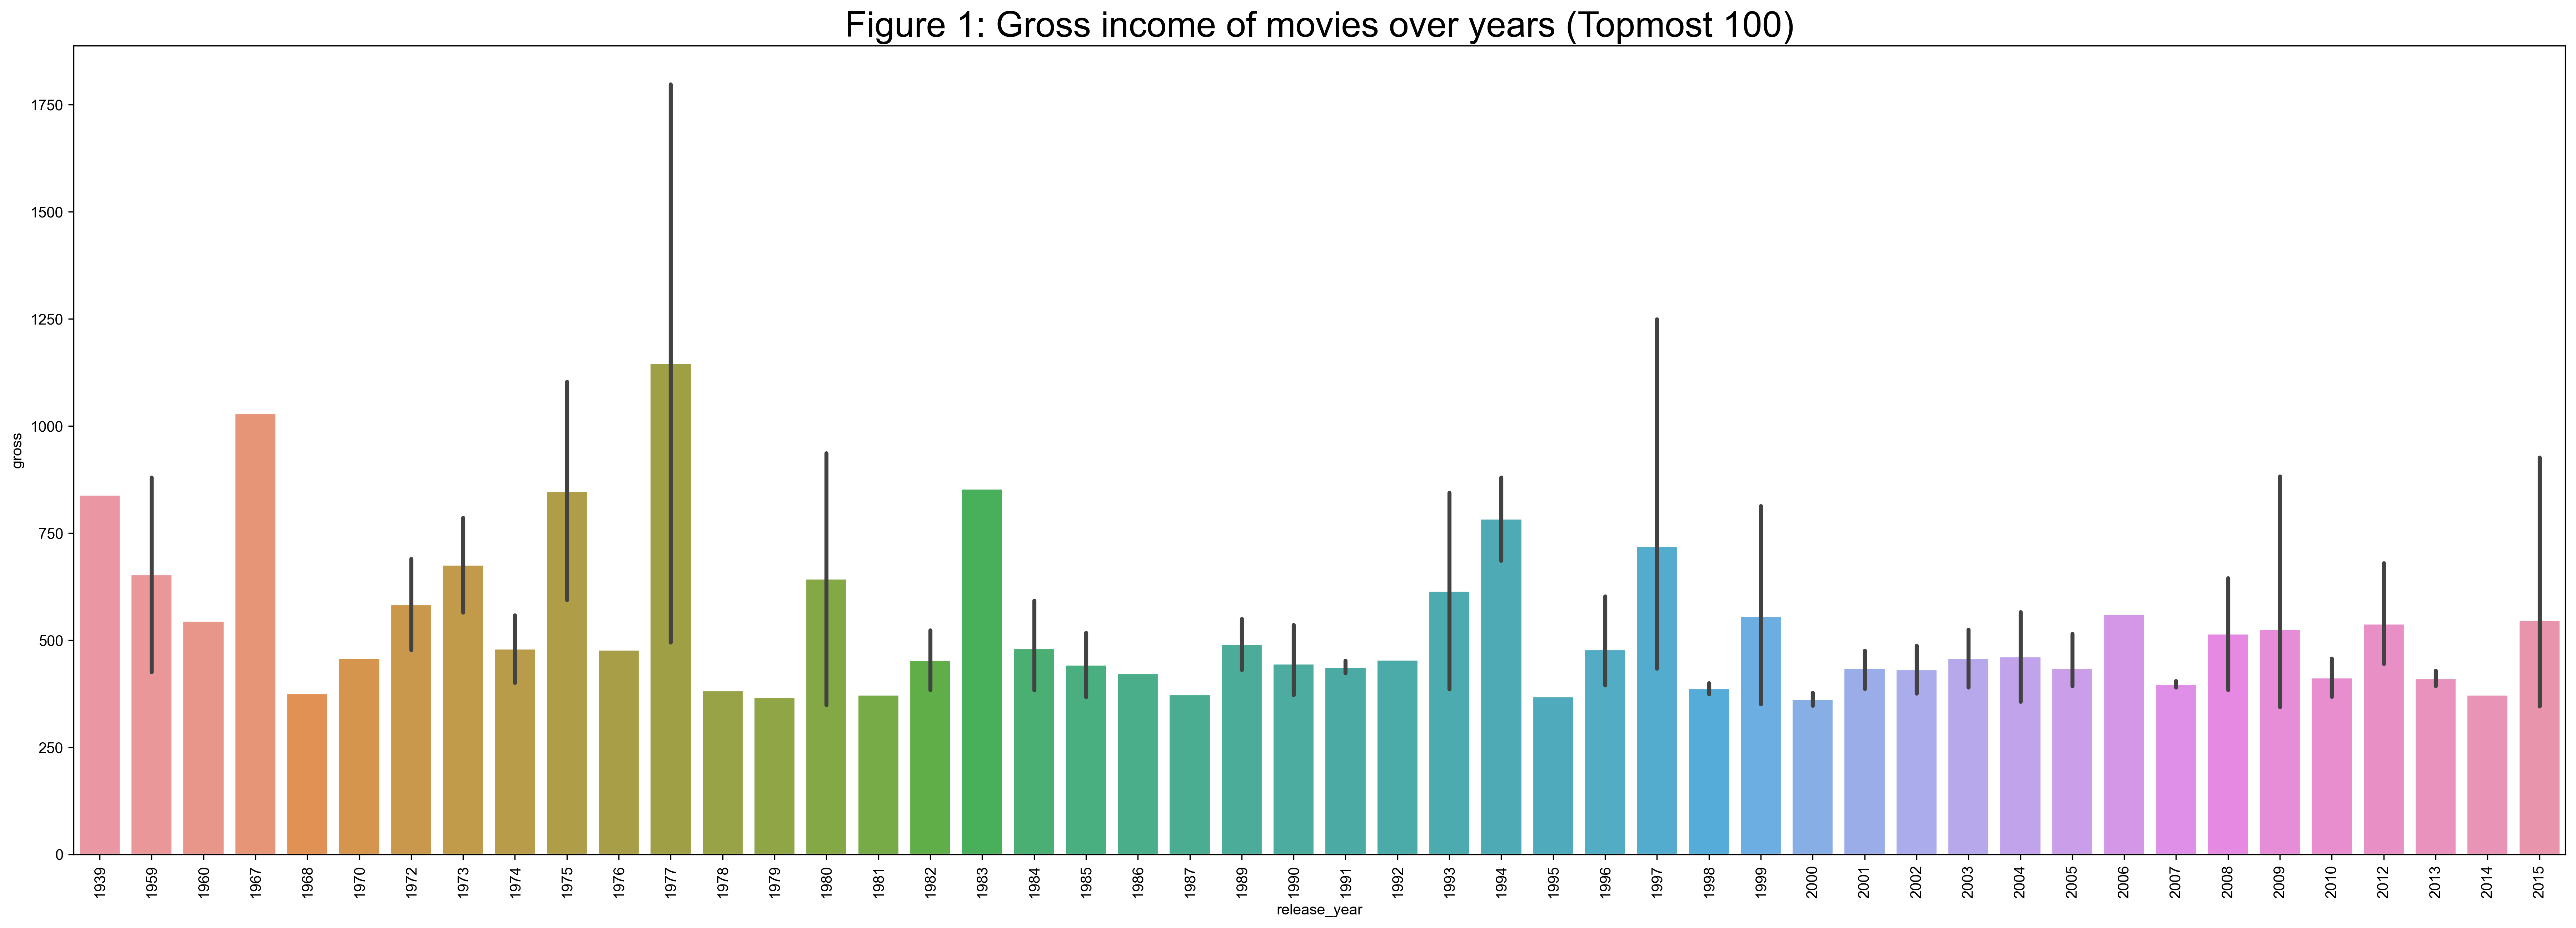

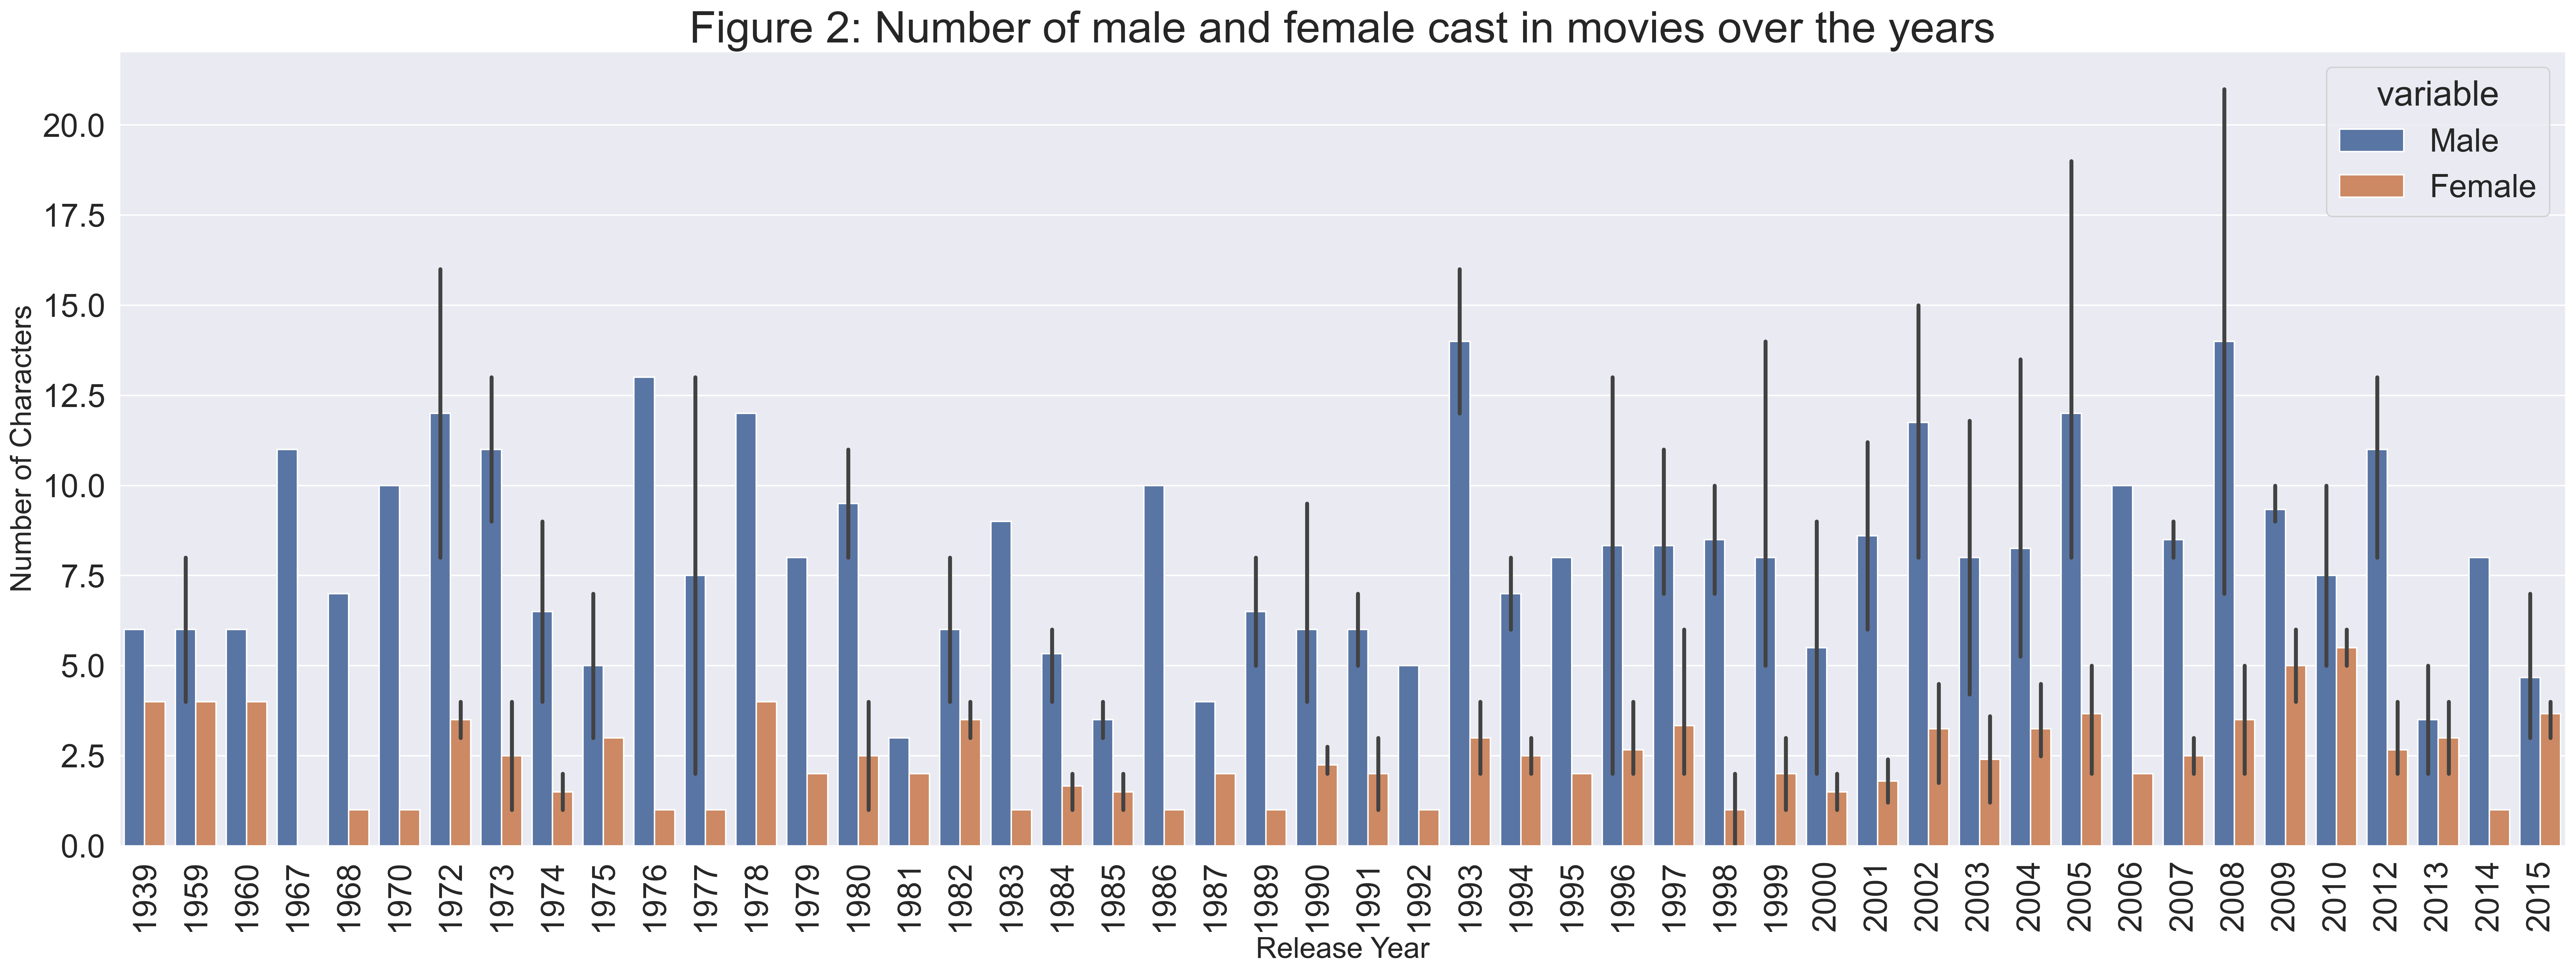

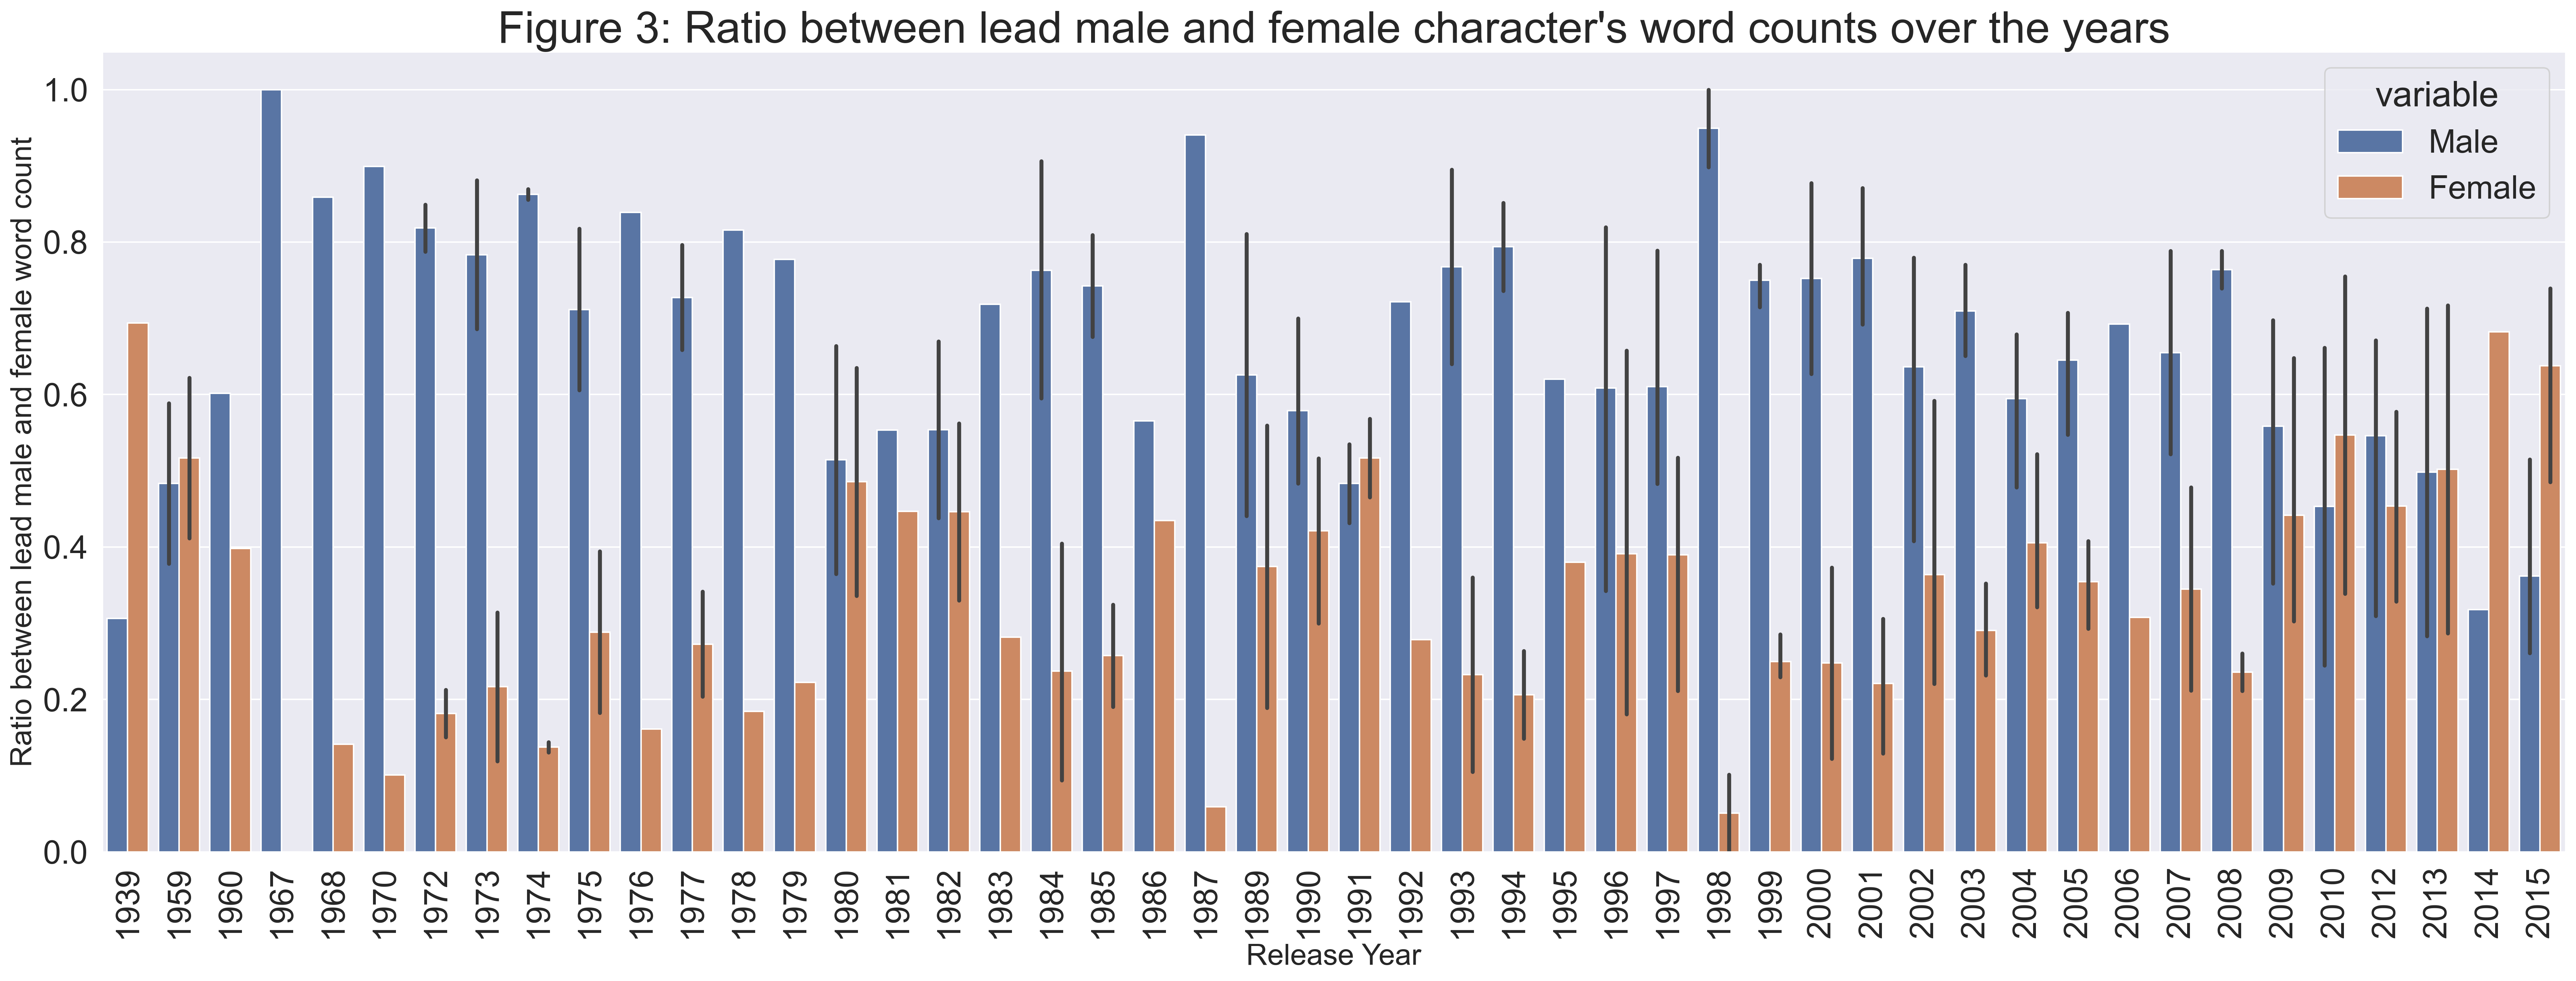

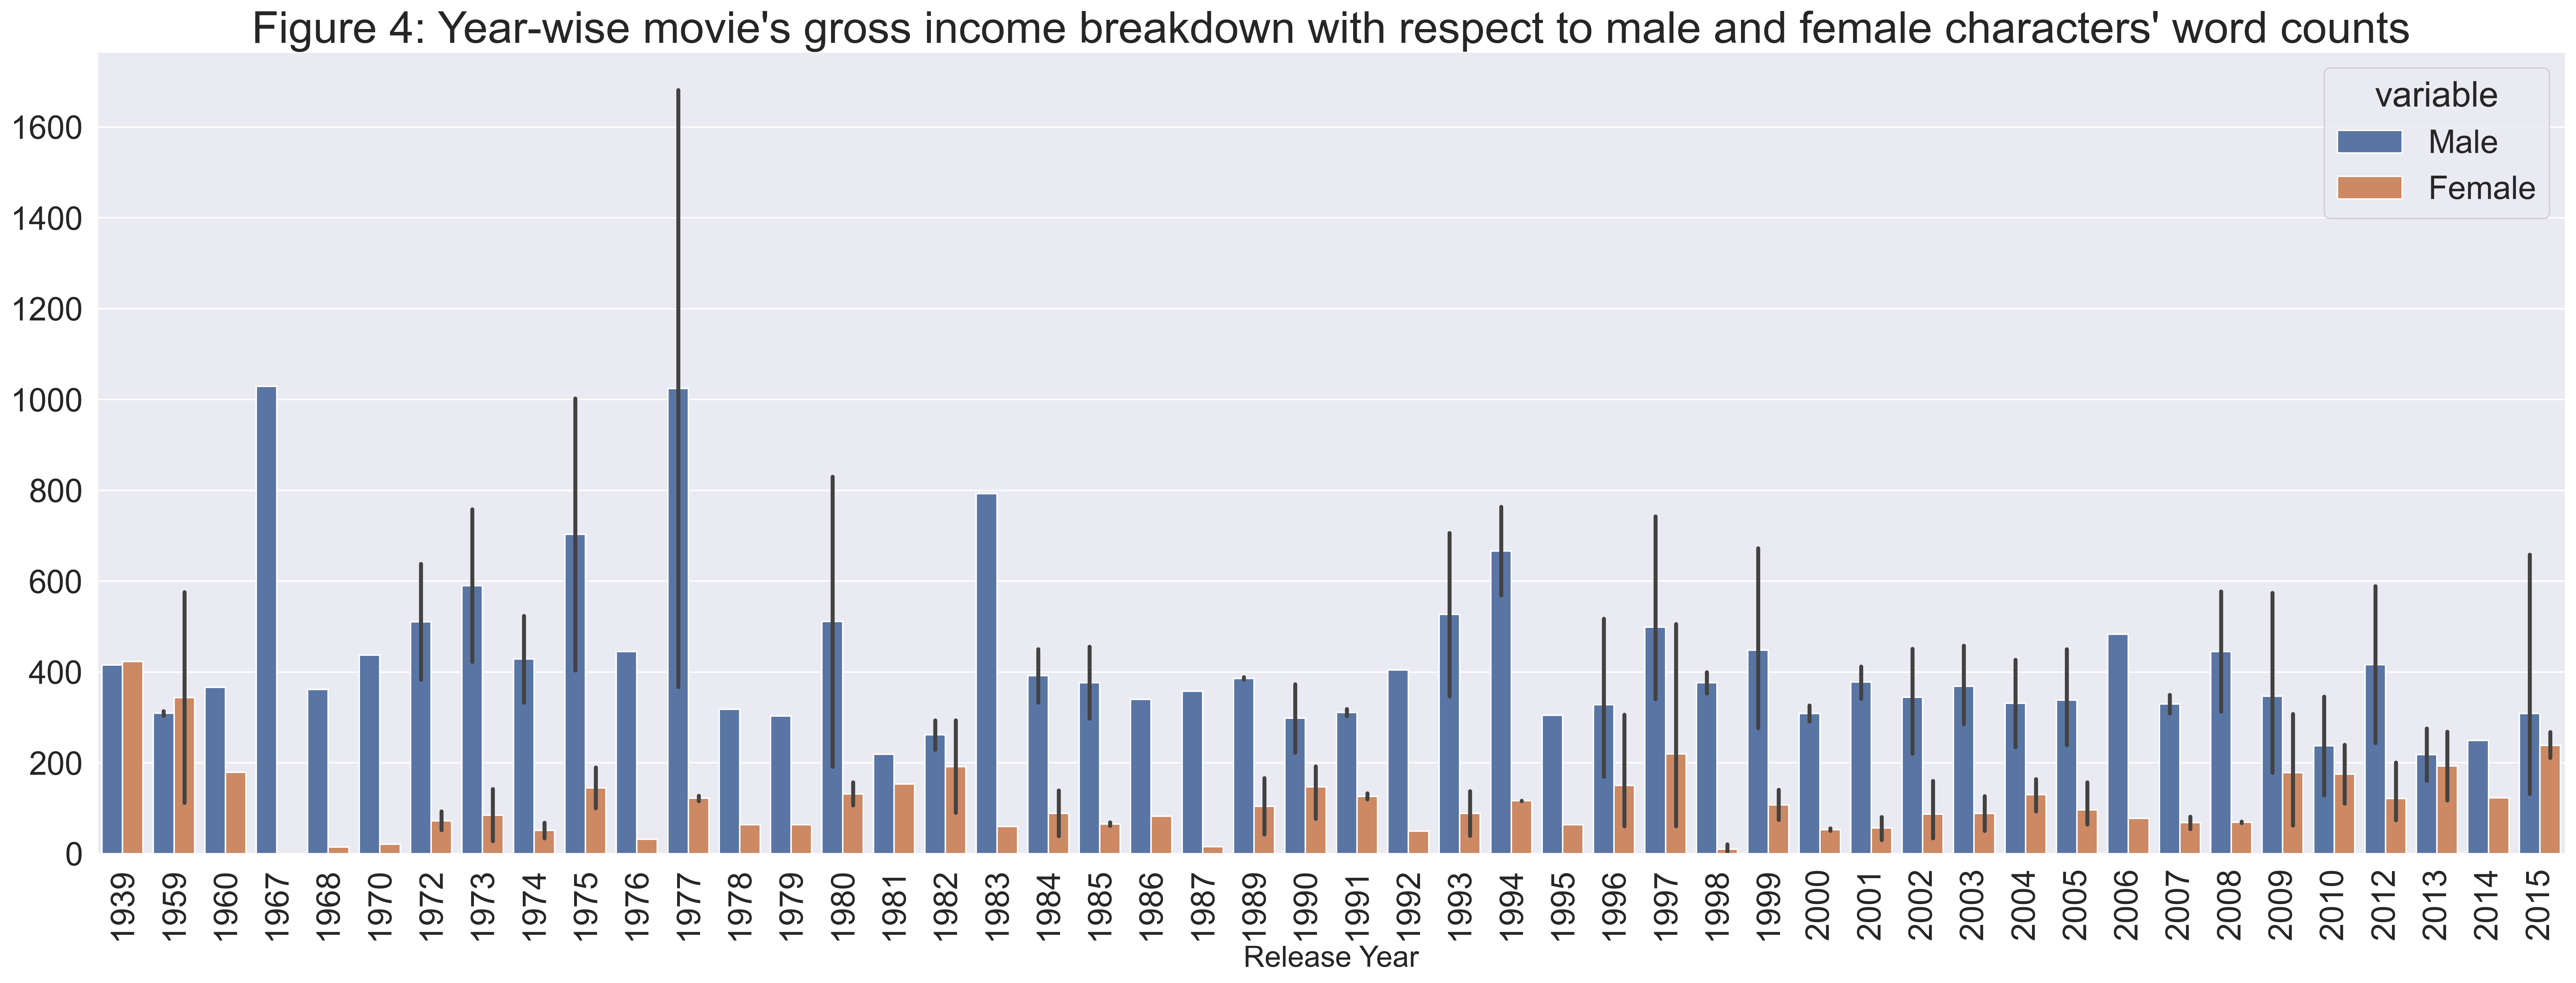

In [16]:
fig, ax = plt.subplots(figsize=(30,10), dpi=300)
sns.set(font_scale=2)
l1 = sns.barplot(x='release_year', y='gross',  data=top_100_gross_income_movies).set(title='Figure 1: Gross income of movies over years (Topmost 100)');
ax.tick_params(axis='x', rotation=90)
########################################################################################

fig, ax = plt.subplots(figsize=(30,10), dpi=300)
sns.set(font_scale=2)
data_preproc = pd.DataFrame({
    'Release Year': new_movie_data_sorted_by_year['release_year'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])], 
    'Male': new_movie_data_sorted_by_year['no_of_male_characters'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])],
    'Female': new_movie_data_sorted_by_year['no_of_female_characters'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])]
    })
ax = sns.barplot(x='Release Year', y='value', hue='variable', data=pd.melt(data_preproc, ['Release Year']));
ax.set_xlabel("Release Year",fontsize=20)
ax.set_ylabel("Number of Characters",fontsize=20)
ax.set_title("Figure 2: Number of male and female cast in movies over the years",fontsize=30)
ax.tick_params(axis='x', rotation=90)
plt.show()
########################################################################################

fig, ax = plt.subplots(figsize=(30,10), dpi=300)
sns.set(font_scale=2)
total_words_of_lead_characters = new_movie_data_sorted_by_year['lead_male_character_word'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])]+new_movie_data_sorted_by_year['lead_female_character_word'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])]
word_of_male_lead = new_movie_data_sorted_by_year['lead_male_character_word'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])]
word_of_female_lead = new_movie_data_sorted_by_year['lead_female_character_word'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])]

data_preproc = pd.DataFrame({
    'Release Year': new_movie_data_sorted_by_year['release_year'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])], 
    'Male': word_of_male_lead/total_words_of_lead_characters,
    'Female': word_of_female_lead/total_words_of_lead_characters
    })
ax = sns.barplot(x='Release Year', y='value', hue='variable', data=pd.melt(data_preproc, ['Release Year']));
ax.set_xlabel("Release Year",fontsize=20)
ax.set_ylabel("Ratio between lead male and female word count",fontsize=20)
ax.tick_params(axis='x', rotation=90)
ax.set_title("Figure 3: Ratio between lead male and female character's word counts over the years",fontsize=30)
plt.show()
########################################################################################

fig, ax = plt.subplots(figsize=(30,10), dpi=300)
sns.set(font_scale=2)
total_words = new_movie_data_sorted_by_year['total_words_male_characters'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])]+new_movie_data_sorted_by_year['total_words_female_characters'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])]
word_of_males = new_movie_data_sorted_by_year['total_words_male_characters'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])]
word_of_females = new_movie_data_sorted_by_year['total_words_female_characters'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])]

total_gross_of_all_100_movies = np.sum(top_100_gross_income_movies['gross'])
movie_gross_ratio = new_movie_data_sorted_by_year['gross'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])] #/total_gross_of_all_100_movies

data_preproc = pd.DataFrame({
    'Release Year': new_movie_data_sorted_by_year['release_year'][new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])], 
    'Male': movie_gross_ratio*(word_of_males/total_words),
    'Female': movie_gross_ratio*(word_of_females/total_words)
    })
ax = sns.barplot(x='Release Year', y='value', hue='variable', data=pd.melt(data_preproc, ['Release Year']));
ax.set_xlabel("Release Year",fontsize=20)
ax.set_ylabel("",fontsize=20)
ax.tick_params(axis='x', rotation=90)
ax.set_title("Figure 4: Year-wise movie's gross income breakdown with respect to male and female characters' word counts",fontsize=30)
plt.show()


#### 1.4.2 Analysis:
- Figure 1 shows the 100 highest gross income made by movies according to their release years. 
- Figure 2, indicates that the number of male characters in movies has always been greater than the number of female characters. This clearly indicates a bias in script writing and relevant character casting. 
- The ratio between the lead (either protagonist or antagonist) male and female characters' screenplay in terms of word counts is shown in figure 3. Although we can see in most of the movies the lead male character has a higher word count ratio than the lead female character, there are trends where the lead female character has a higher word count ratio than the lead male character. So the lead male character tends to dominate the movies in terms of dialogue ratios with respect to the lead female. 
- The gross income of movies broken down to the proportion of dialogue (in terms of word count) produced by male or female characters is shown in figure 4. Although the male portion is greater in most of the cases this can be attributed to greater numbers of male characters in movie than the female characters depicted in figure 2. However, we can also see some movies being placed in the top 100 highest-gross-income movies where the major roles were played by female characters. 
- The association rule mining in section 1.3 indicates that high gross income is relevant to male characters but this may be because of the higher number of male character casting in the movies. However, the contribution to the movie’s gross income is not clear in terms of gender-wise character counts or their word counts because it can also depend on factors such as the number of popular scenes or dialogues produced by either male or female characters. 

#### 1.4.3 High gross income movie with majority screenplay (word count) by female character

In [17]:
new_movie_data_sorted_by_year = new_movie_data_sorted_by_year[new_movie_data_sorted_by_year['title'].isin(top_100_gross_income_movies['title'])]

years = [1939, 1959]
for yr in years:
    female_grossed_movie_name = new_movie_data_sorted_by_year[new_movie_data_sorted_by_year['release_year']==yr]
    female_grossed_movie = female_grossed_movie_name[new_movie_data_sorted_by_year['lead_male_character_word']<new_movie_data_sorted_by_year['lead_female_character_word']]
    print('-'*20)
    print(list(female_grossed_movie['title'])[0],
          ': \n# lead male character word:', list(female_grossed_movie['lead_male_character_word'])[0], 
          '\n# lead female character word:', list(female_grossed_movie['lead_female_character_word'])[0],
          '\n# total female character word:', list(female_grossed_movie['total_words_female_characters'])[0],
          '\n# total male character word:', list(female_grossed_movie['total_words_male_characters'])[0],
          '\n# Gross income:',list(female_grossed_movie['gross'])[0]
         )

--------------------
The Wizard of Oz : 
# lead male character word: 1351 
# lead female character word: 3060 
# total female character word: 4681 
# total male character word: 4595 
# Gross income: 839.0
--------------------
Sleeping Beauty : 
# lead male character word: 656 
# lead female character word: 1079 
# total female character word: 2971 
# total male character word: 1570 
# Gross income: 880.0


#### 1.4.2 High gross income movie with majority screenplay (word count) by male character

In [18]:
years = [1967, 1977]
for yr in years:
    male_grossed_movie_name = new_movie_data_sorted_by_year[new_movie_data_sorted_by_year['release_year']==yr]
    male_grossed_movie = male_grossed_movie_name[new_movie_data_sorted_by_year['lead_male_character_word']>new_movie_data_sorted_by_year['lead_female_character_word']]
    print('-'*20)
    print(list(male_grossed_movie_name['title'])[0],
          ':\n# lead male character word:', list(male_grossed_movie['lead_male_character_word'])[0], 
          '\n# lead female character word:', list(male_grossed_movie['lead_female_character_word'])[0],
          '\n# total female character word:', list(male_grossed_movie['total_words_female_characters'])[0],
          '\n# total male character word:', list(male_grossed_movie['total_words_male_characters'])[0],
          '\n# Gross income:',list(male_grossed_movie_name['gross'])[0]
         )

--------------------
The Jungle Book :
# lead male character word: 1831 
# lead female character word: 0 
# total female character word: 0 
# total male character word: 7060 
# Gross income: 1029.0
--------------------
Star Wars: Episode IV - A New Hope :
# lead male character word: 2485 
# lead female character word: 636 
# total female character word: 636 
# total male character word: 9221 
# Gross income: 1798.0


## 2. Good Performance

In [382]:
scopus_icdm_data_path_info = '../data/scopus_icdm_2017.csv'
scopus_icdm_data = pd.read_csv(scopus_icdm_data_path_info)
# scopus_icdm_data.shape

### 2.1 Preprocessing and parsing

In [383]:
print("# Dataset instances before cleaning:", scopus_icdm_data.shape[0])
missing_val_info= fp.get_missing_data_info(scopus_icdm_data)
print("# Number of instance with nan:",len(missing_val_info['rows']['row_index']))
nan_cleaned_scopus_data = fp.process_missing_value(scopus_icdm_data, drop=True, drop_instance=True)
cleaned_scopus_data = nan_cleaned_scopus_data.drop_duplicates()
print("# Dataset instances after cleaning:", cleaned_scopus_data.shape[0])

# Dataset instances before cleaning: 221
# Number of instance with nan: 4
# Dataset instances after cleaning: 217


In [384]:
scopus_file_directory = '../output/scopus_icdm_2017_transaction.csv'
if not os.path.exists(scopus_file_directory):
    scopus_icdm_data_transaction= psr.parse_scopus_data_to_transaction(cleaned_scopus_data, scopus_file_directory)
else:
    scopus_file_directory = '../output/scopus_icdm_2017_transaction.csv'
    scopus_icdm_data_transaction = pd.read_csv(scopus_file_directory, index_col=[0])
scopus_icdm_data_transaction.head(3)

,transaction
0,"42:Li Huayu, Ge Yong, Zhu Hengshu, Xiong Hui, ..."
1,"5:Fu Yanjie, Aggarwal Charu, Parthasarathy Sri..."
2,"15:Luo Tingjin, Zhang Weizhong, Qiu Shang, Yan..."


In [14]:
scopus_genderize_file_directory = '../output/scopus_icdm_2017_genderized.csv'
if not os.path.exists(scopus_genderize_file_directory):
    df_genderize= psr.parse_scopus_data_using_genderize(scopus_icdm_data_transaction, scopus_genderize_file_directory)
else:
    df_genderize = pd.read_csv(scopus_genderize_file_directory, index_col=[0])
df_genderize.head(2)

,transaction
0,"42,M,M,F,F,M,60119141, 60112903, 60019118, 600..."
1,"5,F,F,M,M,F,60024728, 60017366, 123285669, Uni..."


In [15]:
genderize_feature_eng_df = psr.feature_engineer_scopus_dataset(df_genderize, pub_year='2017')
genderize_feature_eng_df.head(2)

,pub_year,male_auth,female_auth,first_auth_gender,citation
0,2017,3,2,male,42
1,2017,2,3,female,5


In [16]:
association_scopus_df = pd.DataFrame()
bin_labels_3 = ['low', 'medium', 'high']
association_scopus_df['citation'] = pd.qcut(genderize_feature_eng_df['citation'], q=[0, 0.25, 0.75, 1], labels=bin_labels_3)
association_scopus_df['gender'] = genderize_feature_eng_df['first_auth_gender']

In [17]:
print("# Genderize transaction dataset shape before cleaning missing value:", association_scopus_df.shape[0])
missing_val_info= fp.get_missing_data_info(association_scopus_df)
print("# Number of instance with nan:",len(missing_val_info['rows']['row_index']))
cleaned_association_scopus_df = fp.process_missing_value(association_scopus_df, drop=True, drop_instance=True) 
print("# Genderize transaction dataset after cleaning missing value:", cleaned_association_scopus_df.shape[0])
# cleaned_association_scopus_df.head(3)

# Genderize transaction dataset shape before cleaning missing value: 217
# Number of instance with nan: 3
# Genderize transaction dataset after cleaning missing value: 214


### 2.2 Analyzing association of gender with citation of the articles

In [18]:
association_scopus_df_dummies = pd.get_dummies(cleaned_association_scopus_df)
association_scopus_df_enc = association_scopus_df_dummies.replace({0:False, 1:True})

apriori_frequent_itemsets_scopus = apriori(association_scopus_df_enc, min_support=0.1, use_colnames=True)
item_scopus = association_rules(apriori_frequent_itemsets_scopus, metric="confidence", min_threshold=0.8)
item_scopus.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(citation_low),(gender_male),0.257009,0.836449,0.210280,0.818182,0.978162,-0.004695,0.899533
1,(citation_medium),(gender_male),0.490654,0.836449,0.401869,0.819048,0.979197,-0.008538,0.903837
2,(citation_high),(gender_male),0.252336,0.836449,0.224299,0.888889,1.062694,0.013233,1.471963


In [387]:
female_author = cleaned_genderize_feature_eng_df['female_auth']
male_author = cleaned_genderize_feature_eng_df['male_auth']
total_female_author = np.sum(female_author)
total_male_author = np.sum(male_author)

ratio_female_author = total_female_author/(total_female_author+total_male_author)
ratio_male_author = total_male_author/(total_female_author+total_male_author)

print("# Ratio of female writers in the publications:",round(ratio_female_author,2))
print("# Ratio of male writers in the publications:",round(ratio_male_author,2))

# Ratio of female writers in the publications: 0.23
# Ratio of male writers in the publications: 0.77


In [391]:
cleaned_genderize_feature_eng_df = fp.process_missing_value(genderize_feature_eng_df, drop=True, drop_instance=True) 
female_first_author = cleaned_genderize_feature_eng_df[cleaned_genderize_feature_eng_df['first_auth_gender']=='female']
total_female_citation = np.sum(female_first_author['citation'])

male_first_author = cleaned_genderize_feature_eng_df[cleaned_genderize_feature_eng_df['first_auth_gender']=='male']
total_male_citation = np.sum(male_first_author['citation'])

ratio_female_citation = total_female_citation/(total_female_citation+total_male_citation)
ratio_male_citation = total_male_citation/(total_female_citation+total_male_citation)
print("# Citation ratio with first author being female",round(ratio_female_citation,2))
print("# Citation ratio with first author being male",round(ratio_male_citation,2))

# Citation ratio with first author being female 0.2
# Citation ratio with first author being male 0.8


### 2.3 Analysis
- According to the association mining in section 2.2, high citation is relevant to the gender of the first author being male. Moreover, analysis of the dataset shows that the number of male authors is higher than the number of female authors and as a result we can see a higher citation ratio for male first author than the female first author.  

## 3. Excellent Performance:

### 3.1 Getting scopus data for year 2014, 2015, 2016, 2017, 2018

In [ ]:
!python scopus_retrieval.py --year 2014

### 3.2 Preprocessing and parsing scopus data of year 2014, 2015, 2016, 2017, 2018 and getting gender information from genderize API 

In [397]:
years = [2014,2015,2016,2017,2018]

In [448]:
for year in years:
    print("-"*20)
    print("Dataset: scopus_icdm_{}".format(year))
    scopus_icdm_data_path_info = '../data/scopus_icdm_{}.csv'.format(year)
    scopus_icdm_data = pd.read_csv(scopus_icdm_data_path_info)

    print("# Dataset instances before cleaning:", scopus_icdm_data.shape[0])
    missing_val_info= fp.get_missing_data_info(scopus_icdm_data)
    print("# Number of instance with nan:",len(missing_val_info['rows']['row_index']))
    cleaned_scopus_icdm_data = fp.process_missing_value(scopus_icdm_data, drop=True, drop_instance=True)
    cleaned_scopus_icdm_data = cleaned_scopus_icdm_data.drop_duplicates()
    print("# Dataset instances after cleaning:", cleaned_scopus_icdm_data.shape[0])
    
    scopus_file_directory = '../output/scopus_icdm_{}_transaction.csv'.format(year)
    if not os.path.exists(scopus_file_directory):
        scopus_icdm_data_transaction= psr.parse_scopus_data_to_transaction(cleaned_scopus_icdm_data, scopus_file_directory)
    else:
        scopus_icdm_data_transaction = pd.read_csv(scopus_file_directory, index_col=[0])
    
    scopus_genderize_file_directory = '../output/scopus_icdm_{}_genderized.csv'.format(year)
    if not os.path.exists(scopus_genderize_file_directory):
        df_genderize= psr.parse_scopus_data_using_genderize(scopus_icdm_data_transaction, scopus_genderize_file_directory)
    else:
        df_genderize = pd.read_csv(scopus_genderize_file_directory, index_col=[0])

--------------------
Dataset: scopus_icdm_2014
# Dataset instances before cleaning: 210
# Number of instance with nan: 5
# Dataset instances after cleaning: 205
--------------------
Dataset: scopus_icdm_2015
# Dataset instances before cleaning: 241
# Number of instance with nan: 4
# Dataset instances after cleaning: 237
--------------------
Dataset: scopus_icdm_2016
# Dataset instances before cleaning: 219
# Number of instance with nan: 1
# Dataset instances after cleaning: 218
--------------------
Dataset: scopus_icdm_2017
# Dataset instances before cleaning: 221
# Number of instance with nan: 4
# Dataset instances after cleaning: 217
--------------------
Dataset: scopus_icdm_2018
# Dataset instances before cleaning: 296
# Number of instance with nan: 2
# Dataset instances after cleaning: 294


In [454]:
year_vec = []
high_citation_consequent_rule = []
high_citation_confidence = []

female_citation_ratio_vec = []
male_citation_ratio_vec = []

female_author_ratio_vec = []
male_author_ratio_vec = []


for year in years: 
    print("-"*20)
    scopus_genderize_file_directory = '../output/scopus_icdm_{}_genderized.csv'.format(year)
    print("Dataset: scopus_icdm_{}_genderized".format(year))
    df_genderize = pd.read_csv(scopus_genderize_file_directory, index_col=[0])
    
    genderize_feature_eng_df = psr.feature_engineer_scopus_dataset(df_genderize, pub_year=2014)
    print("# Dataset shape before cleaning missing value:", genderize_feature_eng_df.shape)
    missing_val_info= fp.get_missing_data_info(genderize_feature_eng_df)
    print("# Number of instance with nan:",len(missing_val_info['rows']['row_index']))
    cleaned_genderize_feature_eng_df = fp.process_missing_value(genderize_feature_eng_df, drop=True, drop_instance=True)
    print("# Dataset shape after cleaning missing value:", cleaned_genderize_feature_eng_df.shape)
    
    association_scopus_df = pd.DataFrame()
    bin_labels_3 = ['low', 'medium', 'high']
    association_scopus_df['citation'] = pd.qcut(cleaned_genderize_feature_eng_df['citation'], q=[0, 0.25, 0.75, 1], labels=bin_labels_3)
    association_scopus_df['gender'] = cleaned_genderize_feature_eng_df['first_auth_gender']
    
    association_scopus_df_dummies = pd.get_dummies(association_scopus_df)
    association_scopus_df_enc = association_scopus_df_dummies.replace({0:False, 1:True})

    apriori_frequent_itemsets_scopus = apriori(association_scopus_df_enc, min_support=0.1, use_colnames=True)
    item_scopus = association_rules(apriori_frequent_itemsets_scopus, metric="confidence", min_threshold=0.7)
    
    df=item_scopus.copy()
    df['antecedents'] = df['antecedents'].apply(lambda x: ''.join(list(x))).astype("unicode")
    df['consequents'] = df['consequents'].apply(lambda x: ''.join(list(x))).astype("unicode")
    selected_trans = df[df["antecedents"].str.contains("(citation_high)")]
    
    year_vec.append(str(year))
    conseq = list(selected_trans['consequents'])[0]
    high_citation_consequent_rule.append(conseq)
    high_citation_confidence.append(list(selected_trans['confidence'])[0])
    
    female_first_author = cleaned_genderize_feature_eng_df[cleaned_genderize_feature_eng_df['first_auth_gender']=='female']
    total_female_citation = np.sum(female_first_author['citation'])

    male_first_author = cleaned_genderize_feature_eng_df[cleaned_genderize_feature_eng_df['first_auth_gender']=='male']
    total_male_citation = np.sum(male_first_author['citation'])

    ration_female_citation = round(total_female_citation/(total_female_citation+total_male_citation),2)
    ration_male_citation = round(total_male_citation/(total_female_citation+total_male_citation),2)
    
    rate_female_citation = total_female_citation/(female_first_author.shape[0])
    rate_male_citation = total_male_citation/(male_first_author.shape[0])
    
    female_author = cleaned_genderize_feature_eng_df['female_auth']
    male_author = cleaned_genderize_feature_eng_df['male_auth']
    total_female_author = np.sum(female_author)
    total_male_author = np.sum(male_author)

    ration_female_author = total_female_author/(total_female_author+total_male_author)
    ration_male_author = total_male_author/(total_female_author+total_male_author)
        
    avg_female_citation_rate.append(rate_female_citation)
    avg_male_citation_rate.append(rate_male_citation)
    female_citation_ratio_vec.append(ration_female_citation)
    male_citation_ratio_vec.append(ration_male_citation)
    female_author_ratio_vec.append(ration_female_author)
    male_author_ratio_vec.append(ration_male_author)    

--------------------
Dataset: scopus_icdm_2014_genderized
# Dataset shape before cleaning missing value: (205, 5)
# Number of instance with nan: 14
# Dataset shape after cleaning missing value: (191, 5)
--------------------
Dataset: scopus_icdm_2015_genderized
# Dataset shape before cleaning missing value: (237, 5)
# Number of instance with nan: 7
# Dataset shape after cleaning missing value: (230, 5)
--------------------
Dataset: scopus_icdm_2016_genderized
# Dataset shape before cleaning missing value: (218, 5)
# Number of instance with nan: 7
# Dataset shape after cleaning missing value: (211, 5)
--------------------
Dataset: scopus_icdm_2017_genderized
# Dataset shape before cleaning missing value: (217, 5)
# Number of instance with nan: 3
# Dataset shape after cleaning missing value: (214, 5)
--------------------
Dataset: scopus_icdm_2018_genderized
# Dataset shape before cleaning missing value: (294, 5)
# Number of instance with nan: 8
# Dataset shape after cleaning missing value

### 3.3 Visualization of pattern

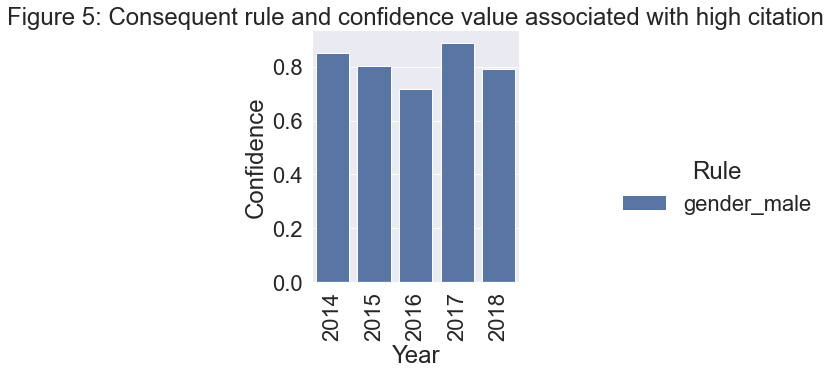

In [452]:
data_preproc_rule = pd.DataFrame({
    'Year': year_vec, 
    'Confidence': high_citation_confidence,
    'Rule': high_citation_consequent_rule
    })
p1 = sns.factorplot(x ='Year', 
                    y ='Confidence', 
                    data = data_preproc_rule, 
                    hue='Rule', 
                    kind='bar', 
                    ax=ax).set(title='Figure 5: Consequent rule and confidence value associated with high citation').set_xticklabels(rotation=90)

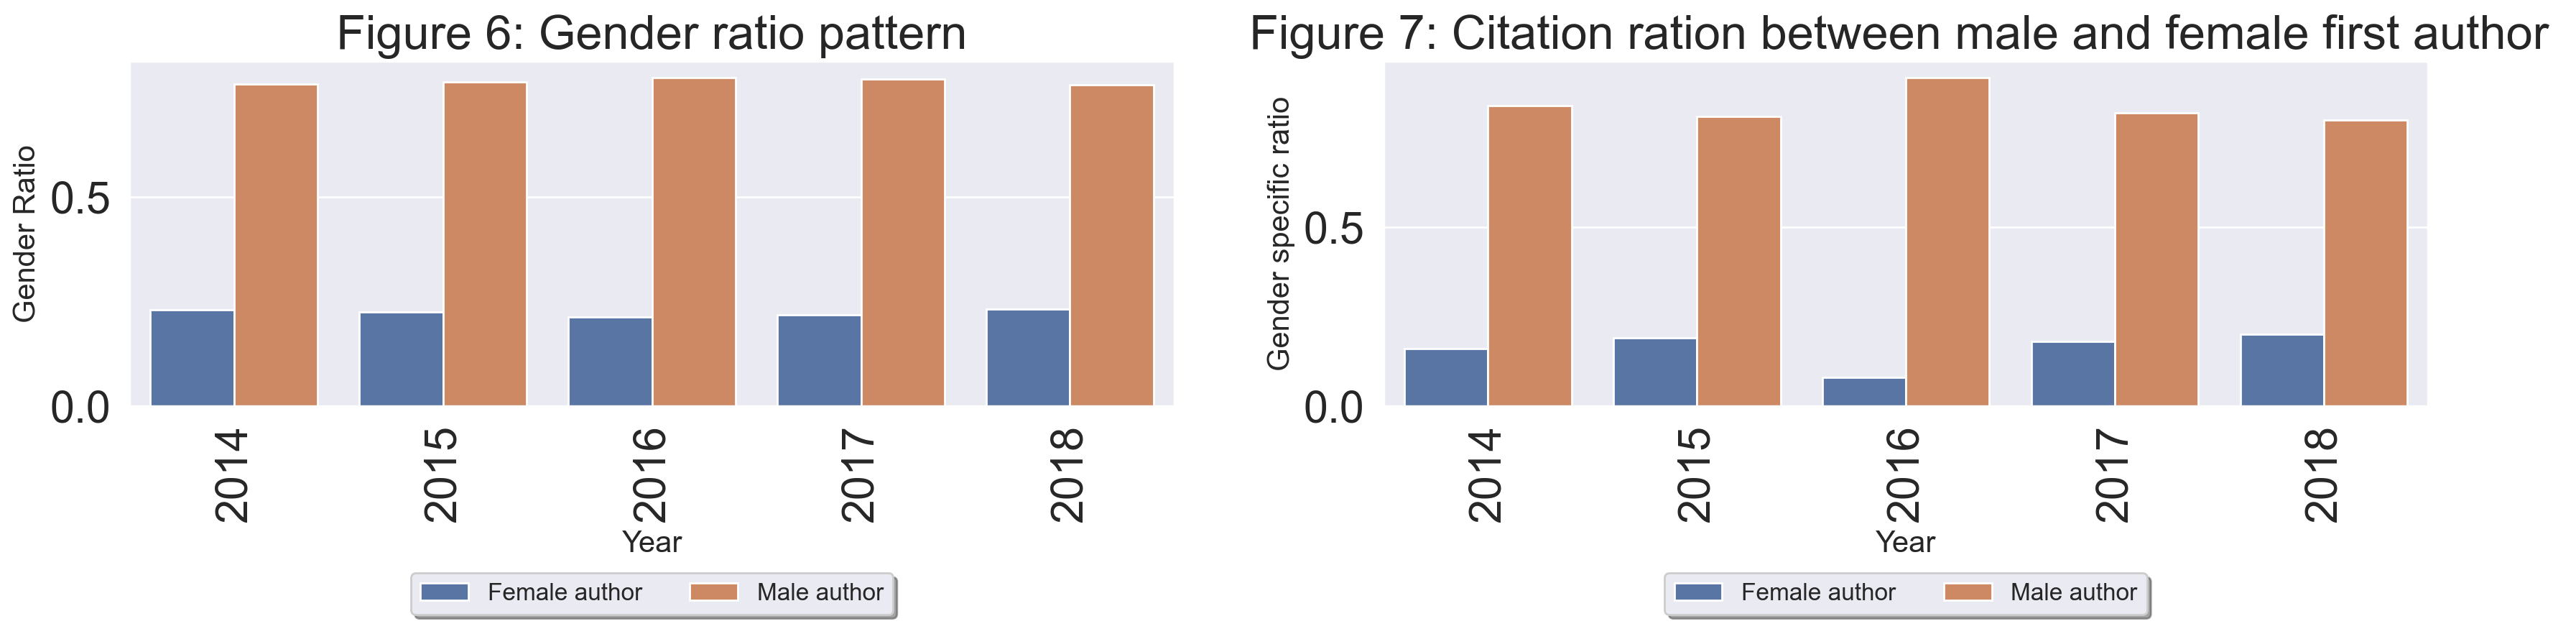

In [458]:
data_preproc1 = pd.DataFrame({
    'Year': year_vec, 
    'Female author': female_author_ratio_vec,
    'Male author': male_author_ratio_vec,
    })

data_preproc2 = pd.DataFrame({
    'Year': year_vec, 
    'Female author': female_citation_ratio_vec,
    'Male author': male_citation_ratio_vec,
    })


fig, axes = plt.subplots(1, 2, figsize=(20,3), dpi=200)
ax1 = sns.barplot(x='Year', y='value', hue='variable', data=pd.melt(data_preproc1, ['Year']), ax=axes[0]);
ax1.set_xlabel("Year",fontsize=15)
ax1.set_ylabel('Gender Ratio',fontsize=15)
ax1.tick_params(axis='x', rotation=90)
ax1.title.set_text("Figure 6: Gender ratio pattern")
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.45), fontsize=12, fancybox=True, shadow=True, ncol=2)


ax2 = sns.barplot(x='Year', y='value', hue='variable', data=pd.melt(data_preproc2, ['Year']), ax=axes[1]);
ax2.set_xlabel("Year",fontsize=15)
ax2.set_ylabel('Gender specific ratio',fontsize=15)
ax2.tick_params(axis='x', rotation=90)
ax2.title.set_text("Figure 7: Citation ration between male and female first author ")
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.45), fontsize=12, fancybox=True, shadow=True, ncol=2)


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)
plt.show()

### 3.4 Analysis
- By analyzing dataset from year 2014 to 2018 it can be seen that articles with male first author has higher citation ratio than female first authors which does not change over time that much. 

## 4. Exceptional Performance:

### 4.1 Preprocessing and parsing data with geolocation information

In [19]:
scopus_icdm_data_path_info = '../data/scopus_icdm_2017.csv'
scopus_icdm_data = pd.read_csv(scopus_icdm_data_path_info)
cleaned_scopus_data = fp.process_missing_value(scopus_icdm_data, drop=True, drop_instance=True)
cleaned_scopus_data = cleaned_scopus_data.drop_duplicates()

In [20]:
scopus_file_directory = '../output/others/scopus_geo_data_2017.csv'
if not os.path.exists(scopus_file_directory):
    scopus_geo_data= psr.parse_scopus_data_to_geo_data(cleaned_scopus_data, scopus_file_directory)
else:
    scopus_file_directory = '../output/others/scopus_geo_data_2017.csv'
    scopus_geo_data = pd.read_csv(scopus_file_directory, index_col=[0])

In [21]:
scopus_geo_data['address']= scopus_geo_data['aff_city'].astype('string')+', '\
                           +scopus_geo_data['aff_country'].astype('string')

In [22]:
missing_val_info= fp.get_missing_data_info(scopus_geo_data)
cleaned_scopus_geo_data = fp.process_missing_value(scopus_geo_data, drop=True, drop_instance=True)

In [23]:
scopus_geo_data.head(2)

,aff_id,aff_university,aff_city,aff_country,address
0,60119141,Rutgers University–New Brunswick,New Brunswick,United States,"New Brunswick, United States"
1,60112903,"Baidu, Inc.",Beijing,China,"Beijing, China"


### 4.2 Sorting authors by their number of publication

In [24]:
i, r = pd.factorize(scopus_geo_data['aff_id'])
a = np.argsort(np.bincount(i)[i], kind='mergesort')
sorted_scopus_data = scopus_geo_data.iloc[a].drop_duplicates(subset='aff_id', keep='first')
sorted_scopus_data.shape

(256, 5)

In [25]:
cleaned_scopus_geo_data = fp.process_missing_value(sorted_scopus_data, drop=True, drop_instance=True)

In [26]:
from geopy.geocoders import Nominatim
def get_coordinates(address):
    """Takes a list of cities and returns a dictionary of the cities and their corresponding coordinates."""
    geo_coordinate = []
    latitude = []
    longitude = []
    geolocator = Nominatim(user_agent="DM HW5")
    for add in tqdm(address):
        try:
            geocode = partial(geolocator.geocode, language="es")
            location = geocode(add)
        except:
            raise Exception("Error with getCoordinates function")
        lat = location.latitude
        long = location.longitude
        latitude.append(lat)
        longitude.append(long)
        coordinate_values = (lat, long)
        coor_point = Point(coordinate_values)
        geo_coordinate.append(coor_point)
    return geo_coordinate,  latitude, longitude

### 4.3 Getting geolocation of top 99 authors (Due to GeoPy API limitation)

In [27]:
scopus_geo_data_file_directory = '../output/others/GeoPy_Author_LocationData_2017.csv'
if not os.path.exists(scopus_geo_data_file_directory):
    geo_list, lat_list, long_list = get_coordinates(cleaned_scopus_geo_data['aff_city'][0:99])
    scopus_geo_data_map = cleaned_scopus_geo_data[0:99]
    scopus_geo_data_map['geo_location']=geo_list
    scopus_geo_data_map['latitude']=lat_list
    scopus_geo_data_map['longitude']=long_list
    scopus_geo_data_map.to_csv(scopus_geo_data_file_directory)
    scopus_geo_data_map.head(3)
else:
    scopus_geo_data_map = pd.read_csv(scopus_geo_data_file_directory, index_col=[0])

### 4.4 Interactive map with folium

In [28]:
author_locations = scopus_geo_data_map[["latitude", "longitude", "aff_university"]]

In [29]:
author_map = folium.Map(location=[author_locations.latitude.mean(),author_locations.longitude.mean()], 
                         zoom_start=1, 
                         tiles='cartodb positron',
                         control_scale=True
                         )
for index, location_info in author_locations.iterrows():
    folium.Marker([location_info["latitude"], location_info["longitude"]], popup=location_info["aff_university"]).add_to(author_map)

In [30]:
author_map   